## Homework 5 - Dive into Deep Learning

#### Ruiqi Zhang

#### Blog:  
https://ruiqi-zhang063.github.io  

#### Github repository
https://github.com/ruiqi-zhang063/ruiqi-zhang063.github.io

#### Import Libraries

The version of tensoflow is 2.5.0

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import shap
import numpy as np
#shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough

In [2]:
tf.__version__

'2.5.0'

#### Load Data

Keep 20% of the training data as the validation dataset.

In [3]:
train_ds = image_dataset_from_directory(
    directory='insects/train',
    labels='inferred',
    label_mode='categorical',
    class_names=['beetles','cockroach','dragonflies'],
    batch_size=32,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(256, 256))
validation_ds = image_dataset_from_directory(
    directory='insects/train',
    labels='inferred',
    label_mode='categorical',
    class_names=['beetles','cockroach','dragonflies'],
    batch_size=32,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(256, 256))
test_ds = image_dataset_from_directory(
    directory='insects/test',
    labels='inferred',
    label_mode='categorical',
    class_names=['beetles','cockroach','dragonflies'],
    batch_size=32,
    image_size=(256, 256))

Found 1019 files belonging to 3 classes.
Using 816 files for training.
Found 1019 files belonging to 3 classes.
Using 203 files for validation.
Found 180 files belonging to 3 classes.


#### Hyperparameter

In [4]:
num_classes = 3
shape = (256,256,3)

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu',input_shape=shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

In [5]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#### Model Training

In [6]:
%%time

hist = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=5, 
    verbose=0)

CPU times: user 5min 20s, sys: 2min 25s, total: 7min 45s
Wall time: 1min 18s


#### Loss and Accuracy in Validation Dataset

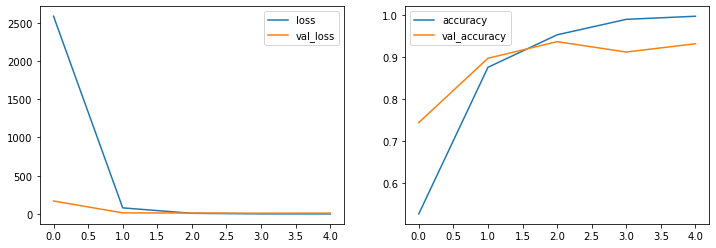

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2,figsize=(12, 4))
for ax, measure in zip(axes, ['loss', 'accuracy']):
    ax.plot(hist.history[measure], label=measure)
    ax.plot(hist.history['val_' + measure], label='val_' + measure)
    ax.legend()
pass

#### Accuracy in Test Dataset

In [8]:
test_loss, test_acc = model.evaluate(test_ds)
test_acc

6/6 [==============================] - 1s 161ms/step - loss: 0.6533 - accuracy: 0.9889


0.9888888597488403

#### Model Explanation

In [9]:
for row, column in train_ds.take(1):
    X_train = row.numpy()

In [10]:
e = shap.DeepExplainer(model, X_train)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [11]:
for row, column in test_ds.take(1):
    X_test = row.numpy()
    Y_test = column.numpy()

In [12]:
np.random.seed(123)
X_index = np.random.choice(X_train.shape[0], 5, replace=False)
X_test_select = X_test[X_index]
Y_test_select = Y_test[X_index]

In [13]:
shape_values = e.shap_values(X_test_select);

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [14]:
index_names = np.array(['beetles','cockroach','dragonflies']*5).reshape(5,3)

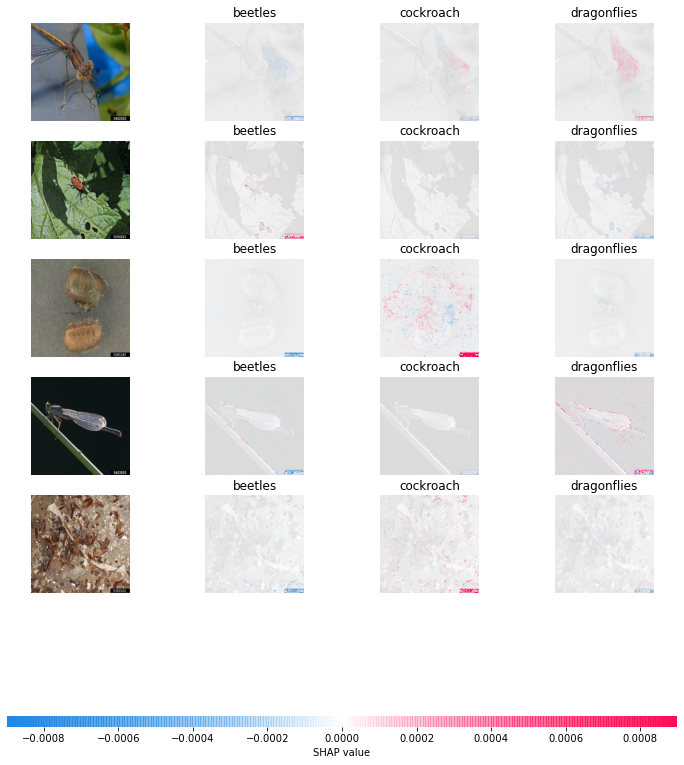

In [15]:
shap.image_plot(shape_values, X_test_select, index_names)

Predictions for two input images are explained in the plot above. Red pixels represent positive SHAP values that increase the probability of the class, while blue pixels represent negative SHAP values the reduce the probability of the class.

We can see that the main basis for classification is the numbers in the lower right corner. Since the results on the test set are still very accurate, it means that the numbers in the lower right corner may have some regularity, which makes classification easier. Besides the numbers in the lower right corner, dragonfly wings and the shape of the cockroach are also used for classification.